BBB Project Part 2
===

- Shows performance of bayes by backprop, a method using Variational Inference on a network

## Import files: same as other BBB project parts

In [2]:
# Add local folders to path
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [3]:
from collections import OrderedDict

import pymc3 as pm
import theano
import theano.tensor as tt

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import mode
from pymc3.theanof import set_tt_rng, MRG_RandomStreams

%matplotlib inline

In [4]:
print('PyMC3 v{}\nTheano v{}'.format(pm.__version__,theano.__version__))

PyMC3 v3.5
Theano v1.0.3


In [5]:
# Set random seeds
np.random.seed(42)
pm.set_tt_rng(42)

In [6]:
# Avoid warnings on batches below
from warnings import filterwarnings
filterwarnings('ignore')

In [7]:
# Use tensorflow to import image datasets
import tensorflow as tf

reshape_train_imgs = lambda img : img.reshape(img.shape[0],-1)
imgvec2img = lambda vec : vec.reshape((np.sqrt(vec.shape[0]).astype(int),np.sqrt(vec.shape[0]).astype(int)))
floatX = theano.config.floatX

dataset = 'fashion_mnist'

if dataset == 'mnist':
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train,X_test = reshape_train_imgs(X_train),reshape_train_imgs(X_test)
    label_dict = OrderedDict({i:str(i) for i in range(10)})
    
    X_train = X_train.astype(floatX)/255
    y_train = y_train.astype(np.int)
    X_test = X_test.astype(floatX)/255
    y_test = y_test.astype(np.int)
    
    n_output = len(label_dict)
    
elif dataset == 'fashion_mnist':
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    X_train,X_test = reshape_train_imgs(X_train),reshape_train_imgs(X_test)
    label_dict = OrderedDict({0: 'T-shirt/top',
                              1: 'Trouser',
                              2: 'Pullover',
                              3: 'Dress',
                              4: 'Coat',
                              5: 'Sandal',
                              6: 'Shirt',
                              7: 'Sneaker',
                              8: 'Bag',
                              9: 'Ankle boot'})
    X_train = X_train.astype(floatX)/255
    y_train = y_train.astype(np.int)
    X_test = X_test.astype(floatX)/255
    y_test = y_test.astype(np.int)
    
    n_output = len(label_dict)

(n_train,n_input) = X_train.shape
print("N Input for {} = {}".format(dataset,n_input))

N Input for fashion_mnist = 784


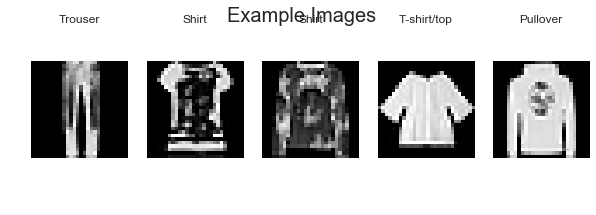

In [8]:
# PLot random subset of images
n_plot_samples = 5
rand_samps = np.random.choice(X_train.shape[0],size=n_plot_samples)

figsize = (10,3); fontsize = 16;
f, axs = plt.subplots(1,n_plot_samples,sharex=True,figsize=figsize);
for rs,ax in zip(rand_samps,axs):
    ax.imshow(imgvec2img(X_train[rs]),cmap='gray');
    ax.axis('off')
    ax.set_title(label_dict[y_train[rs]]);
    sns.despine();
f.suptitle("Example Images",fontsize=fontsize+4);

Use %load magic here to load `bbb_nn.py`. Delete are re-run a cell as below for updates:
```python
%load bbb_nn.py
```

In [9]:
# %load bbb_nn.py
def construct_nn(ann_input, ann_output, n_input, n_output, n_train, n_hidden_1=128):
    
    # Initialize random weights between each layer
    init_w_1 = np.random.randn(n_input, n_hidden_1).astype(theano.config.floatX)
    init_out = np.random.randn(n_hidden_1,n_output).astype(theano.config.floatX)
    
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        w_0_1 = pm.Normal('w_0_1', 0, sd=1, shape=(n_input, n_hidden_1), testval=init_w_1)
     
        # Weights from hidden layer to output
        w_1_out = pm.Normal('w_2_out', 0, sd=1,shape=(n_hidden_1,n_output),testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.Deterministic('act_1',var=pm.math.tanh(pm.math.dot(ann_input,w_0_1)))#+b_1))
        
        # Softmax is required at last layer
        act_out = pm.Deterministic('act_out',var=tt.nnet.softmax(pm.math.dot(act_1,w_1_out)))
    
        # Classification
        out = pm.Categorical('out',act_out,observed=ann_output,total_size=n_train)
        
    return neural_network

## Application: Active Learning with fashion_mnist

One of the main benefits of using a Bayesian Neural Network is that it is possile to drive learning online accoring to where the network is most uncertain. This is often referred to as active learning. We are going to apply active learning to training a BNN for classification on the fashion_mnist dataset. Our hope is that we can speed up learning by feeding the network data according to which categories it is the most uncertain about. 

**Brief Overview**

When we started working on this problem we were suprised to see that with a very small fraction of the training dataset we still got decent performance on the test set with our BNN. For example, with the full training dataset (60,000 images) we get a test set performance of 77%, while with only 300 data points we still get 71% performance. This was based on 10K iterations (~8 epochs), so it is possible that the assymptoic performance of the networks with this amount of data would be more different. In any case, these findings made us interested in how performance depends on the number of data points. 

In order to investigate this we trained a network on varying amounts of training data. This would have taken a very long time with our BNN, so instead we used a network with the same structure, but trained with adam in tensorflow. We found that the learning curve as a function of training data is highly nonlinear. Specifically, there is a large increase in performance between 50 and 200 training data points, and then a linear increase between 200 and 60000. 

For the purpose of exploring active learning with this example dataset, we are going to focus on speeding up the improvement in performance within the first ~500 training data points seen. 

**Outline**

1. Get an idea the learning curve as a function of the amount of training data
2. Example of training on subset of data and assessing uncertainty
3. Active learning application

### 1) Assess test performance as a function of number of training data points

Before moving on with active learning, we want to get a sense of how test set performace depends on the number of training samples. It would be pretty slow to look at this with out pymc3 model, but we can use Adam optimization in tensorflow to get an idea of the learning curve on an ANN. 

In [135]:
from tensorflow import keras

def tf_model(X_train, y_train):
    model = keras.Sequential([
        keras.layers.Dense(128, activation=tf.nn.tanh),
        keras.layers.Dense(n_output, activation=tf.nn.softmax)
    ])

    model.compile(optimizer=tf.train.AdamOptimizer(), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=5)
    test_loss, test_acc = model.evaluate(X_test, y_test)
    
    return test_acc
    
test_acc = tf_model(X_train, y_train)
print('Test accuracy:', test_acc)

Epoch 1/5
60000/60000 [==============================] - 8s 136us/step - loss: 0.4770 - acc: 0.8297
Epoch 2/5
60000/60000 [==============================] - 9s 158us/step - loss: 0.3707 - acc: 0.8658
Epoch 3/5
60000/60000 [==============================] - 8s 130us/step - loss: 0.3364 - acc: 0.8769
Epoch 4/5
60000/60000 [==============================] - 7s 123us/step - loss: 0.3147 - acc: 0.8838
Epoch 5/5
10000/10000 [==============================] - 1s 96us/step
Test accuracy: 0.8759


In [145]:
n_samples_vec = [10,20, 30, 40, 50, 70, 100, 150, 200, 500, 1000, 10000, 60000]

n_trials = 5
test_acc_results = np.zeros((len(n_samples_vec), n_trials))
for i, n_samples in enumerate(n_samples_vec):
    print(n_samples)
    for j in range(n_trials):
        X_train_subset, y_train_subset = get_training_subset(X_train, y_train, n_samples)
        test_acc = tf_model(X_train_subset, y_train_subset)
        test_acc_results[i,j] = test_acc

[10, 20, 30, 40, 50, 70, 100, 150, 200, 500, 1000, 10000, 60000]
10
Epoch 1/5
9/9 [==============================] - 2s 239ms/step - loss: 2.4269 - acc: 0.1111
Epoch 2/5
9/9 [==============================] - 0s 684us/step - loss: 1.7624 - acc: 0.4444
Epoch 3/5
9/9 [==============================] - 0s 774us/step - loss: 1.2923 - acc: 0.5556
Epoch 4/5
9/9 [==============================] - 0s 822us/step - loss: 0.9105 - acc: 1.0000
Epoch 5/5
10000/10000 [==============================] - 2s 208us/step
Epoch 1/5
9/9 [==============================] - 2s 231ms/step - loss: 2.4940 - acc: 0.2222
Epoch 2/5
9/9 [==============================] - 0s 754us/step - loss: 1.9537 - acc: 0.4444
Epoch 3/5
9/9 [==============================] - 0s 630us/step - loss: 1.5194 - acc: 0.4444
Epoch 4/5
9/9 [==============================] - 0s 797us/step - loss: 1.1550 - acc: 0.8889
Epoch 5/5
10000/10000 [==============================] - 2s 204us/step
Epoch 1/5
9/9 [==============================] - 2s 24

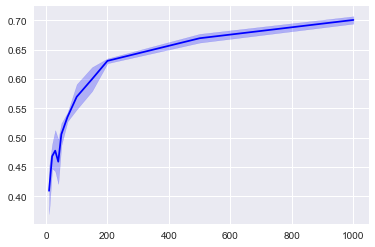

In [182]:
mean_perf = np.mean(test_acc_results, axis=1)
std_perf = np.std(test_acc_results, axis=1)
num_points_plot = 11
plt.plot(n_samples_vec[:num_points_plot], mean_perf[:num_points_plot], c='blue')
plt.fill_between(n_samples_vec[:num_points_plot], mean_perf[:num_points_plot]+std_perf[:num_points_plot], mean_perf[:num_points_plot]-std_perf[:num_points_plot], color='blue', alpha=.25)
plt.show()

The relationship between the number of training data points and test set performance is highly nonlinear. We see a large jump in performance between 10 and 200 training data points, and then a pretty linear increase from then on. With this model, we don't reach assymptotic performance even with the full dataset (though this might not be true if we increase the number of iterations). As mentioned abve, we are going to focus on increasing the speed of learning at the beginning of training (~500 training points). 

### 2) Example of training network on subset of data and assessing uncertainty


We will now go through an example of training a BNN on a subset of the data. We will used a balanced subset of 200 training data points. As we will from the confusion matrix, there is an uneven distribution of uncertainty across categories. Hopefully by using active learning, we can give the network appropraite data during training to efficiently reduce the uncertainty.  

#### Functions for trainining on subset and assessing uncertainty

In [20]:
import scipy as sp

def get_training_subset(X_train, y_train, n_samples):
    (n_train, n_input) = np.shape(X_train)
    n_cat = 10
    if n_train == n_samples:
        return X_train, y_train
    # make n_samples a multiple of 10 for ease of balancing the dataset
    n_cat_samples = int(n_samples/10)
    # get appropraite number of samples from each category
    cat_ind = list()
    ind_array = np.arange(n_train)
    for cat in range(n_cat):
        cat_ind = np.append(cat_ind, np.random.choice(ind_array[y_train == cat], size=n_cat_samples, replace=False))
    np.random.shuffle(cat_ind)
    X_train_subset = X_train[cat_ind.astype(int)]
    y_train_subset = y_train[cat_ind.astype(int)]
    return X_train_subset, y_train_subset

def get_cat_entropy(X_test, y_test, ppc_test):
    # get other parameters that need
    (n_test,n_input) = X_test.shape
    n_output = 10
    n_samples = np.shape(ppc_test['out'])[0]
    
    # make one-hot matrix
    one_hot = np.zeros((n_samples, n_test, n_output))
    for i in range(n_samples):
        one_hot[i][np.arange(n_test), ppc_test['out'][i]] = 1
    
    # make histograms 
    y_test_dist = np.histogram(y_test, bins=n_output)[0]
    cat_hist = np.zeros((n_output, n_output))
    cat_entropy = np.zeros(n_output)
    cat_KL = np.zeros(n_output)
    histograms = np.sum(one_hot, axis=0)
    for i in range(n_output):
        cat_hist[i,:] = np.sum(histograms[y_test == i], axis=0)
        cat_entropy[i] = sp.stats.entropy(cat_hist[i,:])
        cat_KL[i] = sp.stats.entropy(cat_hist[i,:], y_test_dist)
#         cat_KL[i] = sp.stats.entropy(y_test_dist, cat_hist[i,:])
    return one_hot, cat_hist, cat_entropy, cat_KL

#### Train Network on subset of data

In [11]:
n_samples = 200
X_train_subset, y_train_subset = get_training_subset(X_train, y_train, n_samples)

NN_model = construct_nn(X_train_subset, y_train_subset, n_input, n_output, n_samples, n_hidden_1=128)

In [12]:
# convergence not great, use a different method for conv check after:
# https://docs.pymc.io/notebooks/variational_api_quickstart.html
with NN_model:
    advi = pm.ADVI()
    
# After the bayes by BackProp paper!
print(advi.approx.shared_params)

n_approx_iter = 10000
with NN_model:
    approx = advi.fit(n=n_approx_iter)

{'mu': mu, 'rho': rho}


Average Loss = 5,215.8: 100%|██████████| 10000/10000 [02:51<00:00, 67.64it/s]
Finished [100%]: Average Loss = 5,207.9


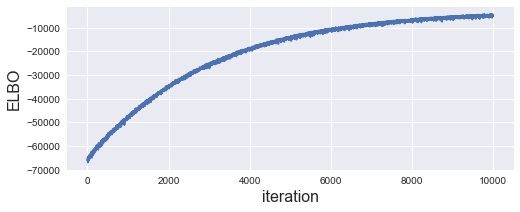

In [13]:
# plotting the training progress
elbo_1 = -advi.hist

figsize = (8,3); fontsize = 16;
f, ax = plt.subplots(1,1,figsize=figsize);

ax.plot(elbo_1,label='1')
ax.set_ylabel('ELBO',fontsize=fontsize)
ax.set_xlabel('iteration',fontsize=fontsize);
sns.despine();

#### Test this network performance on test set

In [14]:
# Draw samples from variational posterior (the weights in the network)
n_draws = 500 # > 2k hangs for almost all network sizes on my 2018 MBP -SH
trace = approx.sample(draws=n_draws)

In [15]:
# network at performance on the test set
(n_test,n_input) = X_test.shape
test_x = theano.shared(X_test)
test_y = theano.shared(y_test)
NN_model_test = construct_nn(test_x, test_y, n_input, n_output, n_test, n_hidden_1=128)
n_samples = 100
with NN_model_test:
    ppc_test = pm.sample_ppc(trace, samples=n_samples)

100%|██████████| 100/100 [00:51<00:00,  2.01it/s]


In [16]:
# Prediction is mode of each
test_y_pred = mode(ppc_test['out'], axis=0).mode[0,:]

mean_test_perf = np.mean(test_y_pred==y_test)
print("Network Test Set Performance: {:f}".format(mean_test_perf))

Network Test Set Performance: 0.704600


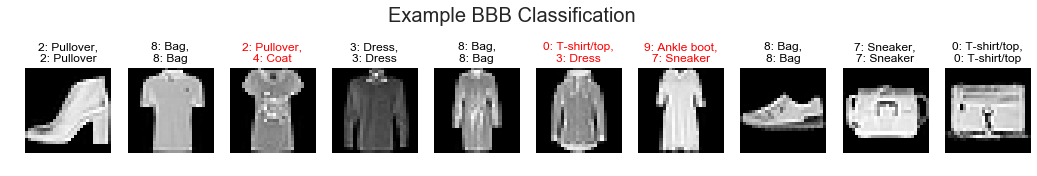

In [17]:
# PLot random subset of images
n_plot_samples = 10
rand_samps = np.random.choice(X_test.shape[0],size=n_plot_samples)

figsize = (18,3); fontsize = 16;
f, axs = plt.subplots(1, n_plot_samples, figsize=figsize);

for rs,ax in zip(rand_samps,axs):
    ax.imshow(imgvec2img(X_train[rs]),cmap='gray');
    tl = "{}: {},\n{}: {}".format(test_y_pred[rs],label_dict[test_y_pred[rs]],y_test[rs],label_dict[y_test[rs]])
    if test_y_pred[rs] == y_test[rs]:
        ax.set_title(tl,color='k');
    else:
        ax.set_title(tl,color='r');
    ax.axis('off');
    sns.despine();
    
f.suptitle("Example BBB Classification",fontsize=fontsize+4);

#### Evaluate uncertainty within each category

Here we are measurign uncertainty as the KL between the network categorization and the actual distribution of y labels. If the training set is balance, the distribution of y labels will be a uniform distibution. A category that outputs almost a unifrom distribution is very uncertain (low KL), while a network that outputs something close to a one-hot vector is very certain (high KL). Consequently, a category with low KL has high uncertainty, and a category with high KL has low uncertainty.

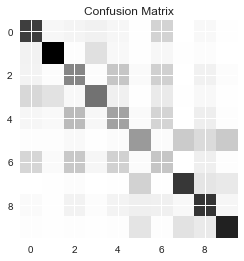

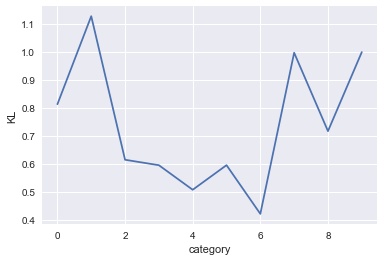

In [43]:
one_hot, cat_hist, cat_entropy, cat_KL = get_cat_entropy(X_test, y_test, ppc_test)
plt.figure(figsize=(4,4))
plt.imshow(cat_hist)
plt.title('Confusion Matrix')
plt.show()
plt.figure(figsize=(6,4))
plt.plot(cat_KL, label='KL')
# plt.legend()
plt.xlabel('category')
plt.ylabel('KL')
plt.show()

These results are pretty interesting. We already get pretty good performance (70%), but it is clear that the middle categories are much more uncertain than the outer categories. We will see if we can remedy this with active learning. 

### 3) Full example

#### Pseudocode

- Train network on subset of training data
- while num_training_data_used < 500
    - assess category uncertainty of network
    - choose 5 training samples from  category with largest uncertainty 
    - choose already seen training data to replay proportional to category uncertainty
    - train network using replay plus new data

**1) How to assess uncertainty while training?** In order to assess the uncertainty of the network we are going to test the network on training data that it has already seen. We want to assess this prior to feeding the network more data. If we were to assess the uncertainty on all seen data, this would take a long time. The benefit of the BBN is that we can get a measure of uncertainty for a single data point. This is still a bit noisy if we want to find the overal category with the highest uncertainty. We choose to assess the uncertainty using 3 data points from each category. 

**2) How many data points should we feed the network after assessing the uncertainty?** We want to avoid overfitting by feeding the network tons of data in a row from the same category. In order to avoid this we will feed the network data in chunks of 5. Also, since the uncertainty assessment is bound to be slightly noisy, we will probably not consistently identify one category as the most uncertain. This will also help avoid overfitting. 

**3) How to use multiple epochs with active learning?** One complication that comes up with active learning is how to adapt the idea of training over multiple epochs of the data. The example aboce runs through about 8 epochs of the training set subset. If it only does 1 epoch, performance is much worse. In order to mimic going though multiple epochs, we will introduce experience replay in conjunction with active learning. For expereince replay, we will choose 10 already seen training points in proportion to the uncertainty of each category.  

#### Helper functions for active learning

Variables to keep track of: 
- ind_used: nested list of used training samples
- ind_remaining: nested list of remaining training samples


In [201]:
def get_training_subset_init(X_train, y_train, n_samples):
    # make n_samples a multiple of 10 for ease of balancing the dataset
    n_cat = 10
    n_cat_samples = int(n_samples/10)
    n_train = np.shape(X_train)[0]
    ind_array = np.arange(n_train)
    
    # make cat list
    ind_remaining = list()
    for i in range(10):
        ind_remaining.append(ind_array[y_train == i])
    
    ind_used = [[]]*n_cat
    ind_subset = list()
    for cat in range(n_cat):
        cat_ind = np.random.choice(ind_remaining[cat], size=n_cat_samples, replace=False).astype(int)
        ind_remaining[cat] = np.delete(ind_remaining[cat], np.argwhere(np.in1d(ind_remaining[cat], cat_ind)))
        ind_used[cat] = np.append(ind_used[cat], cat_ind)
        ind_subset = np.append(ind_subset, cat_ind)
    ind_subset = ind_subset.astype(int)
    np.random.shuffle(ind_subset)
    X_train_subset = X_train[ind_subset]
    y_train_subset = y_train[ind_subset]
    return X_train_subset, y_train_subset, ind_used, ind_remaining

def get_cat_subset(X_train, y_train, ind_used, ind_remaining, n_samples, cat):
    # get appropraite number of samples from given category
    cat_ind = np.random.choice(ind_remaining[cat], size=n_samples, replace=False).astype(int)
    ind_used[cat] = np.append(ind_used[cat], cat_ind)
    ind_remaining[cat] = np.delete(ind_remaining[cat], np.argwhere(np.in1d(ind_remaining[cat], cat_ind)))
    X_train_subset = X_train[cat_ind]
    y_train_subset = y_train[cat_ind]
    return X_train_subset, y_train_subset, ind_used, ind_remaining

def get_used_subset(X_train, y_train, ind_used, n_samples):
    n_cat = 10
    n_cat_samples = int(n_samples/n_cat)
    cat_ind_list = list()
    for cat in range(n_cat):
        cat_ind = np.random.choice(ind_used[cat], size=n_cat_samples, replace=False)
        cat_ind_list = np.append(cat_ind_list, cat_ind)
    cat_ind_list = cat_ind_list.astype(int)
    X_used_subset = X_train[cat_ind_list]
    y_used_subset = y_train[cat_ind_list]
    return X_used_subset, y_used_subset

def get_max_uncertainty(X_train, y_train, ind_used, n_samples):
    X_used_subset, y_used_subset = get_used_subset(X_train, y_train, ind_used, n_samples)
    (n_test,n_input) = X_test.shape
    X_used_shared = theano.shared(X_used_subset)
    y_used_shared = theano.shared(y_used_subset)
    n_input = 28*28
    n_output = 10
    NN_model_test = construct_nn_active_learning(X_used_shared, y_used_shared, n_input, n_output, n_hidden=128)
    n_samples = 100
    with NN_model_test:
        ppc_test = pm.sample_ppc(trace, samples=n_samples)
    one_hot, cat_hist, cat_entropy, cat_KL = get_cat_entropy(X_used_subset, y_used_subset, ppc_test)
    return cat_KL, np.argmin(cat_KL)

def get_replay_subset(X_train, y_train, ind_used, cat_KL, n_samples):
    cat_KL_scaled = ((cat_KL - np.min(cat_KL))/(np.max(cat_KL) - np.min(cat_KL)))
    p_vals = (1 - cat_KL_scaled)/np.sum(cat_KL_scaled)
    p_vals /= np.sum(p_vals)
    n_cat_samples = np.round((p_vals*n_samples)).astype(int)
    cat_ind_list = list()
    for cat, n_cat_samp in enumerate(n_cat_samples):
        if n_cat_samp < len(ind_used[cat]):
            cat_ind = np.random.choice(ind_used[cat], size=n_cat_samp, replace=False)
        elif n_cat_samp >= len(ind_used[cat]):
            cat_ind = ind_used[cat]
        cat_ind_list = np.append(cat_ind_list, cat_ind)
    cat_ind_list = cat_ind_list.astype(int)
    X_replay_subset = X_train[cat_ind_list]
    y_replay_subset = y_train[cat_ind_list]
    return X_replay_subset, y_replay_subset

def get_replay_subset_balanced(X_train, y_train, ind_used, n_samples):
    n_cat = 10
    n_cat_samp = int(n_samples/n_cat)
    cat_ind_list = list()
    for cat in range(n_cat):
        if n_cat_samp < len(ind_used[cat]):
            cat_ind = np.random.choice(ind_used[cat], size=n_cat_samp, replace=False)
        elif n_cat_samp >= len(ind_used[cat]):
            cat_ind = ind_used[cat]
        cat_ind_list = np.append(cat_ind_list, cat_ind)
    cat_ind_list = cat_ind_list.astype(int)
    X_replay_subset = X_train[cat_ind_list]
    y_replay_subset = y_train[cat_ind_list]
    return X_replay_subset, y_replay_subset

#### Neural network for active learning

This network is identical to the BNN used above, expect that we are no longer using minibatches

In [202]:
# %load bbb_nn.py
def construct_nn_active_learning(ann_input, ann_output, n_input, n_output, n_hidden=128):
    
    # Initialize random weights between each layer
    init_w_1 = np.random.randn(n_input, n_hidden).astype(theano.config.floatX)
    init_out = np.random.randn(n_hidden,n_output).astype(theano.config.floatX)
    
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        w_0_1 = pm.Normal('w_0_1', 0, sd=1, shape=(n_input, n_hidden), testval=init_w_1)
     
        # Weights from hidden layer to output
        w_1_out = pm.Normal('w_2_out', 0, sd=1,shape=(n_hidden,n_output),testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.Deterministic('act_1',var=pm.math.tanh(pm.math.dot(ann_input,w_0_1)))#+b_1))
        
        # Softmax is required at last layer
        act_out = pm.Deterministic('act_out',var=tt.nnet.softmax(pm.math.dot(act_1,w_1_out)))
    
        # Classification
        out = pm.Categorical('out',act_out,observed=ann_output)
        
    return neural_network

#### Active learning functions

In [203]:
def initialize_network(X_train, y_train, n_samples, n_epochs):
    X_train_init, y_train_init, ind_used, ind_remaining = get_training_subset_init(X_train, y_train, n_samples)
    shared_x = theano.shared(X_train_init)
    shared_y = theano.shared(y_train_init)

    # make neural network
    (n_train,n_input) = X_train_init.shape
    n_output = 10
    NN_model = construct_nn_active_learning(shared_x, shared_y, n_input, n_output, n_hidden=128)

    # train network on initial subset of data
    n_approx_iter = n_samples*n_epochs
    with NN_model:
        advi = pm.ADVI()
        approx = advi.fit(n=n_approx_iter)
        
    return NN_model, advi, approx, ind_used, ind_remaining

def run_active_learning(NN_model_active, advi_active, ind_used, ind_remaining, n_active_learning_iterations, n_test_uncertainty,
                        n_cat_data_points, n_replay_data_points):
    i = 1
    while i < n_active_learning_iterations: #samples_remaining:
        print(i)
        # evaluate current uncertainty and find category with max uncertainty
        cat_KL, cat = get_max_uncertainty(X_train, y_train, ind_used, n_test_uncertainty)
        # get n_cat_data_points new training data from that category
        X_train_cat, y_train_cat, ind_used, ind_remaining = \
                get_cat_subset(X_train, y_train, ind_used, ind_remaining, n_cat_data_points, cat)
        # get replay training data proportional to current uncertainty
        X_train_replay, y_train_replay = \
            get_replay_subset(X_train, y_train, ind_used, cat_KL, n_replay_data_points)
        # concatenate training data for this active learning iteration
        X_train_subset = np.vstack((X_train_cat, X_train_replay))
        y_train_subset = np.append(y_train_cat, y_train_replay)
        # continue training network on this data
        shared_x.set_value(X_train_subset)
        shared_y.set_value(y_train_subset)
        n_iterations = len(y_train_subset)
        with NN_model_active:
            approx_active = advi_active.fit(n=n_iterations)
        i += 1
    return advi_active, approx_active, ind_used
                        
def run_active_learning_control(NN_model_control, advi_control, ind_used, ind_remaining, n_active_learning_iterations,
                                n_cat_data_points, n_replay_data_points):
    i = 1
    while i < n_active_learning_iterations: #samples_remaining:
        print(i)
        # choose random category to feed data
        cat = np.random.choice(n_output)
        # get n_cat_data_points new training data from that category
        X_train_cat, y_train_cat, ind_used, ind_remaining = \
                get_cat_subset(X_train, y_train, ind_used, ind_remaining, n_cat_data_points, cat)
        # get balanced replay training data
        X_train_replay, y_train_replay = \
            get_replay_subset_balanced(X_train, y_train, ind_used, n_replay_data_points)
        # concatenate training data for this active learning iteration
        X_train_subset = np.vstack((X_train_cat, X_train_replay))
        y_train_subset = np.append(y_train_cat, y_train_replay)
        # continue training network on this data
        shared_x.set_value(X_train_subset)
        shared_y.set_value(y_train_subset)
        n_iterations = len(y_train_subset)
        with NN_model_control:
            approx_control = advi_control.fit(n=n_iterations)
        i += 1
    return advi_control, approx_control, ind_used

#### Run active learning and active learning control

In [212]:
n_initial_samples = 50
n_epochs = 4
n_active_learning_iterations = 100
n_test_uncertainty = 30
n_cat_data_points = 5
n_replay_data_points = 50

print('RUNNING ACTIVE LEARNING')
# initialize model
NN_model_active, advi_active, approx_active, ind_used, ind_remaining = \
    initialize_network(X_train, y_train, n_initial_samples, n_epochs)
# run active learning
advi_active, approx_active, ind_used_active = run_active_learning(
    NN_model_active, advi_active, ind_used, ind_remaining, n_active_learning_iterations, 
    n_test_uncertainty, n_cat_data_points, n_replay_data_points)

print('RUNNING ACTIVE LEARNING CONTROL')
# initialize model
NN_model_control, advi_control, approx_control, ind_used, ind_remaining = \
    initialize_network(X_train, y_train, n_initial_samples, n_epochs)
# run active learning control
advi_control, approx_control, ind_used_control = run_active_learning_control(
    NN_model_control, advi_control, ind_used, ind_remaining, n_active_learning_iterations,
    n_cat_data_points, n_replay_data_points)

RUNNING ACTIVE LEARNING


Average Loss = 60,423: 100%|██████████| 200/200 [00:02<00:00, 68.08it/s]
Finished [100%]: Average Loss = 60,326


1


Average Loss = 57,512: 100%|██████████| 50/50 [00:00<00:00, 57.81it/s]
Finished [100%]: Average Loss = 57,418


2


Average Loss = 56,183: 100%|██████████| 50/50 [00:00<00:00, 66.32it/s]
Finished [100%]: Average Loss = 56,098


3


Average Loss = 54,911: 100%|██████████| 52/52 [00:00<00:00, 58.89it/s]
Finished [100%]: Average Loss = 54,900


4


Average Loss = 53,666: 100%|██████████| 52/52 [00:00<00:00, 73.57it/s]
Finished [100%]: Average Loss = 53,656


5


Average Loss = 52,457: 100%|██████████| 51/51 [00:00<00:00, 70.98it/s]
Finished [100%]: Average Loss = 52,457


6


Average Loss = 51,381: 100%|██████████| 52/52 [00:00<00:00, 72.75it/s]
Finished [100%]: Average Loss = 51,370


7


Average Loss = 50,179: 100%|██████████| 51/51 [00:00<00:00, 71.48it/s]
Finished [100%]: Average Loss = 50,179


8


Average Loss = 49,070: 100%|██████████| 52/52 [00:00<00:00, 72.51it/s]
Finished [100%]: Average Loss = 49,067


9


Average Loss = 47,945: 100%|██████████| 52/52 [00:00<00:00, 70.56it/s]
Finished [100%]: Average Loss = 47,934


10


Average Loss = 46,883: 100%|██████████| 53/53 [00:00<00:00, 70.49it/s]
Finished [100%]: Average Loss = 46,863


11


Average Loss = 45,774: 100%|██████████| 53/53 [00:00<00:00, 59.99it/s]
Finished [100%]: Average Loss = 45,749


12


Average Loss = 44,782: 100%|██████████| 45/45 [00:00<00:00, 73.56it/s]
Finished [100%]: Average Loss = 44,758


13


Average Loss = 43,803: 100%|██████████| 54/54 [00:00<00:00, 74.32it/s]
Finished [100%]: Average Loss = 43,779


14


Average Loss = 42,733: 100%|██████████| 54/54 [00:00<00:00, 72.41it/s]
Finished [100%]: Average Loss = 42,718


15


Average Loss = 41,718: 100%|██████████| 56/56 [00:00<00:00, 60.83it/s]
Finished [100%]: Average Loss = 41,684


16


Average Loss = 40,762: 100%|██████████| 54/54 [00:00<00:00, 75.19it/s]
Finished [100%]: Average Loss = 40,748


17


Average Loss = 39,741: 100%|██████████| 53/53 [00:00<00:00, 70.86it/s]
Finished [100%]: Average Loss = 39,728


18


Average Loss = 38,840: 100%|██████████| 54/54 [00:00<00:00, 75.20it/s]
Finished [100%]: Average Loss = 38,812


19


Average Loss = 37,946: 100%|██████████| 56/56 [00:00<00:00, 72.26it/s]
Finished [100%]: Average Loss = 37,914


20


Average Loss = 36,989: 100%|██████████| 54/54 [00:00<00:00, 70.08it/s]
Finished [100%]: Average Loss = 36,959


21


Average Loss = 36,096: 100%|██████████| 53/53 [00:00<00:00, 75.39it/s]
Finished [100%]: Average Loss = 36,072


22


Average Loss = 35,212: 100%|██████████| 55/55 [00:00<00:00, 67.38it/s]
Finished [100%]: Average Loss = 35,185


23


Average Loss = 34,399: 100%|██████████| 55/55 [00:00<00:00, 69.05it/s]
Finished [100%]: Average Loss = 34,356


24


Average Loss = 33,581: 100%|██████████| 54/54 [00:00<00:00, 72.53it/s]
Finished [100%]: Average Loss = 33,552


25


Average Loss = 32,743: 100%|██████████| 54/54 [00:00<00:00, 72.97it/s]
Finished [100%]: Average Loss = 32,723


26


Average Loss = 31,946: 100%|██████████| 54/54 [00:00<00:00, 74.65it/s]
Finished [100%]: Average Loss = 31,912


27


Average Loss = 31,142: 100%|██████████| 54/54 [00:00<00:00, 73.39it/s]
Finished [100%]: Average Loss = 31,124


28


Average Loss = 30,377: 100%|██████████| 54/54 [00:00<00:00, 74.04it/s]
Finished [100%]: Average Loss = 30,356


29


Average Loss = 29,646: 100%|██████████| 54/54 [00:00<00:00, 72.66it/s]
Finished [100%]: Average Loss = 29,628


30


Average Loss = 28,898: 100%|██████████| 52/52 [00:00<00:00, 71.46it/s]
Finished [100%]: Average Loss = 28,887


31


Average Loss = 28,269: 100%|██████████| 54/54 [00:00<00:00, 75.91it/s]
Finished [100%]: Average Loss = 28,241


32


Average Loss = 27,513: 100%|██████████| 52/52 [00:00<00:00, 69.66it/s]
Finished [100%]: Average Loss = 27,510


33


Average Loss = 26,848: 100%|██████████| 55/55 [00:00<00:00, 69.18it/s]
Finished [100%]: Average Loss = 26,830


34


Average Loss = 26,239: 100%|██████████| 54/54 [00:00<00:00, 73.99it/s]
Finished [100%]: Average Loss = 26,216


35


Average Loss = 25,547: 100%|██████████| 56/56 [00:00<00:00, 70.98it/s]
Finished [100%]: Average Loss = 25,534


36


Average Loss = 24,903: 100%|██████████| 55/55 [00:00<00:00, 73.26it/s]
Finished [100%]: Average Loss = 24,880


37


Average Loss = 24,264: 100%|██████████| 54/54 [00:00<00:00, 71.05it/s]
Finished [100%]: Average Loss = 24,240


38


Average Loss = 23,700: 100%|██████████| 55/55 [00:00<00:00, 72.16it/s]
Finished [100%]: Average Loss = 23,676


39


Average Loss = 23,078: 100%|██████████| 55/55 [00:00<00:00, 67.81it/s]
Finished [100%]: Average Loss = 23,063


40


Average Loss = 22,545: 100%|██████████| 55/55 [00:00<00:00, 71.63it/s]
Finished [100%]: Average Loss = 22,528


41


Average Loss = 22,020: 100%|██████████| 55/55 [00:00<00:00, 71.00it/s]
Finished [100%]: Average Loss = 21,983


42


Average Loss = 21,413: 100%|██████████| 53/53 [00:00<00:00, 72.20it/s]
Finished [100%]: Average Loss = 21,404


43


Average Loss = 20,858: 100%|██████████| 52/52 [00:00<00:00, 63.05it/s]
Finished [100%]: Average Loss = 20,856


44


Average Loss = 20,429: 100%|██████████| 54/54 [00:00<00:00, 73.26it/s]
Finished [100%]: Average Loss = 20,407


45


Average Loss = 19,880: 100%|██████████| 55/55 [00:00<00:00, 67.12it/s]
Finished [100%]: Average Loss = 19,860


46


Average Loss = 19,401: 100%|██████████| 54/54 [00:00<00:00, 62.92it/s]
Finished [100%]: Average Loss = 19,386


47


Average Loss = 18,916: 100%|██████████| 55/55 [00:00<00:00, 66.87it/s]
Finished [100%]: Average Loss = 18,913


48


Average Loss = 18,441: 100%|██████████| 54/54 [00:00<00:00, 73.07it/s]
Finished [100%]: Average Loss = 18,438


49


Average Loss = 17,958: 100%|██████████| 54/54 [00:00<00:00, 57.82it/s]
Finished [100%]: Average Loss = 17,953


50


Average Loss = 17,507: 100%|██████████| 55/55 [00:00<00:00, 65.56it/s]
Finished [100%]: Average Loss = 17,505


51


Average Loss = 17,080: 100%|██████████| 54/54 [00:00<00:00, 56.83it/s]
Finished [100%]: Average Loss = 17,069


52


Average Loss = 16,651: 100%|██████████| 54/54 [00:00<00:00, 74.39it/s]
Finished [100%]: Average Loss = 16,638


53


Average Loss = 16,283: 100%|██████████| 53/53 [00:00<00:00, 54.64it/s]
Finished [100%]: Average Loss = 16,273


54


Average Loss = 15,876: 100%|██████████| 54/54 [00:00<00:00, 59.14it/s]
Finished [100%]: Average Loss = 15,864


55


Average Loss = 15,539: 100%|██████████| 55/55 [00:01<00:00, 54.82it/s]
Finished [100%]: Average Loss = 15,526


56


Average Loss = 15,077: 100%|██████████| 54/54 [00:00<00:00, 69.01it/s]
Finished [100%]: Average Loss = 15,065


57


Average Loss = 14,732: 100%|██████████| 55/55 [00:00<00:00, 69.52it/s]
Finished [100%]: Average Loss = 14,722


58


Average Loss = 14,372: 100%|██████████| 55/55 [00:00<00:00, 70.10it/s]
Finished [100%]: Average Loss = 14,354


59


Average Loss = 13,976: 100%|██████████| 55/55 [00:01<00:00, 43.22it/s]
Finished [100%]: Average Loss = 13,965


60


Average Loss = 13,644: 100%|██████████| 54/54 [00:01<00:00, 52.88it/s]
Finished [100%]: Average Loss = 13,636


61


Average Loss = 13,330: 100%|██████████| 55/55 [00:01<00:00, 46.20it/s]
Finished [100%]: Average Loss = 13,325


62


Average Loss = 13,029: 100%|██████████| 54/54 [00:00<00:00, 71.66it/s]
Finished [100%]: Average Loss = 13,026


63


Average Loss = 12,662: 100%|██████████| 54/54 [00:00<00:00, 65.41it/s]
Finished [100%]: Average Loss = 12,654


64


Average Loss = 12,350: 100%|██████████| 54/54 [00:00<00:00, 66.54it/s]
Finished [100%]: Average Loss = 12,347


65


Average Loss = 12,015: 100%|██████████| 55/55 [00:00<00:00, 61.16it/s]
Finished [100%]: Average Loss = 12,009


66


Average Loss = 11,740: 100%|██████████| 54/54 [00:00<00:00, 62.71it/s]
Finished [100%]: Average Loss = 11,735


67


Average Loss = 11,485: 100%|██████████| 56/56 [00:01<00:00, 43.75it/s]
Finished [100%]: Average Loss = 11,468


68


Average Loss = 11,167: 100%|██████████| 54/54 [00:00<00:00, 55.68it/s]
Finished [100%]: Average Loss = 11,160


69


Average Loss = 10,954: 100%|██████████| 51/51 [00:00<00:00, 73.03it/s]
Finished [100%]: Average Loss = 10,954


70


Average Loss = 10,659: 100%|██████████| 55/55 [00:00<00:00, 71.80it/s]
Finished [100%]: Average Loss = 10,657


71


Average Loss = 10,418: 100%|██████████| 55/55 [00:01<00:00, 53.90it/s]
Finished [100%]: Average Loss = 10,410


72


Average Loss = 10,145: 100%|██████████| 55/55 [00:00<00:00, 59.08it/s]
Finished [100%]: Average Loss = 10,149


73


Average Loss = 9,947: 100%|██████████| 54/54 [00:00<00:00, 66.86it/s]
Finished [100%]: Average Loss = 9,941.2


74


Average Loss = 9,683.8: 100%|██████████| 54/54 [00:00<00:00, 57.47it/s]
Finished [100%]: Average Loss = 9,679.4


75


Average Loss = 9,423.2: 100%|██████████| 55/55 [00:00<00:00, 74.14it/s]
Finished [100%]: Average Loss = 9,413.8


76


Average Loss = 9,196.6: 100%|██████████| 55/55 [00:00<00:00, 73.99it/s]
Finished [100%]: Average Loss = 9,189.8


77


Average Loss = 9,003.5: 100%|██████████| 55/55 [00:00<00:00, 75.14it/s]
Finished [100%]: Average Loss = 9,002.3


78


Average Loss = 8,739.7: 100%|██████████| 53/53 [00:00<00:00, 61.72it/s]
Finished [100%]: Average Loss = 8,735.6


79


Average Loss = 8,548.4: 100%|██████████| 53/53 [00:00<00:00, 64.51it/s]
Finished [100%]: Average Loss = 8,538.3


80


Average Loss = 8,387.2: 100%|██████████| 55/55 [00:00<00:00, 66.27it/s]
Finished [100%]: Average Loss = 8,378.8


81


Average Loss = 8,156: 100%|██████████| 54/54 [00:00<00:00, 73.79it/s]
Finished [100%]: Average Loss = 8,150.9


82


Average Loss = 8,051: 100%|██████████| 54/54 [00:00<00:00, 65.20it/s]
Finished [100%]: Average Loss = 8,035.6


83


Average Loss = 7,806.5: 100%|██████████| 55/55 [00:00<00:00, 66.45it/s]
Finished [100%]: Average Loss = 7,797.7


84


Average Loss = 7,607.5: 100%|██████████| 56/56 [00:00<00:00, 71.83it/s]
Finished [100%]: Average Loss = 7,592.1


85


Average Loss = 7,452.3: 100%|██████████| 55/55 [00:00<00:00, 71.68it/s]
Finished [100%]: Average Loss = 7,446.7


86


Average Loss = 7,253.3: 100%|██████████| 54/54 [00:00<00:00, 70.20it/s]
Finished [100%]: Average Loss = 7,247


87


Average Loss = 7,134.1: 100%|██████████| 56/56 [00:00<00:00, 68.39it/s]
Finished [100%]: Average Loss = 7,124.4


88


Average Loss = 6,913.6: 100%|██████████| 55/55 [00:00<00:00, 66.70it/s]
Finished [100%]: Average Loss = 6,898.6


89


Average Loss = 6,762.5: 100%|██████████| 55/55 [00:00<00:00, 72.45it/s]
Finished [100%]: Average Loss = 6,750.1


90


Average Loss = 6,623.8: 100%|██████████| 53/53 [00:00<00:00, 72.18it/s]
Finished [100%]: Average Loss = 6,619.9


91


Average Loss = 6,509.5: 100%|██████████| 55/55 [00:00<00:00, 71.02it/s]
Finished [100%]: Average Loss = 6,501.3


92


Average Loss = 6,344.5: 100%|██████████| 55/55 [00:00<00:00, 71.61it/s]
Finished [100%]: Average Loss = 6,343.8


93


Average Loss = 6,186.8: 100%|██████████| 53/53 [00:00<00:00, 70.60it/s]
Finished [100%]: Average Loss = 6,182.1


94


Average Loss = 6,078.9: 100%|██████████| 54/54 [00:00<00:00, 70.11it/s]
Finished [100%]: Average Loss = 6,078.2


95


Average Loss = 5,912.6: 100%|██████████| 55/55 [00:00<00:00, 66.34it/s]
Finished [100%]: Average Loss = 5,913.4


96


Average Loss = 5,781.6: 100%|██████████| 55/55 [00:00<00:00, 70.88it/s]
Finished [100%]: Average Loss = 5,781.2


97


Average Loss = 5,675.3: 100%|██████████| 54/54 [00:00<00:00, 63.87it/s]
Finished [100%]: Average Loss = 5,674.2


98


Average Loss = 5,555.5: 100%|██████████| 56/56 [00:00<00:00, 66.00it/s]
Finished [100%]: Average Loss = 5,555.1


99


Average Loss = 5,485.9: 100%|██████████| 54/54 [00:01<00:00, 52.90it/s]
Finished [100%]: Average Loss = 5,476.1


RUNNING ACTIVE LEARNING CONTROL


Average Loss = 60,221: 100%|██████████| 200/200 [00:03<00:00, 66.03it/s]
Finished [100%]: Average Loss = 60,118


1


Average Loss = 57,206: 100%|██████████| 55/55 [00:00<00:00, 75.64it/s]
Finished [100%]: Average Loss = 57,151


2


Average Loss = 55,794: 100%|██████████| 55/55 [00:00<00:00, 75.34it/s]
Finished [100%]: Average Loss = 55,740


3


Average Loss = 54,545: 100%|██████████| 55/55 [00:00<00:00, 75.31it/s]
Finished [100%]: Average Loss = 54,490


4


Average Loss = 53,275: 100%|██████████| 55/55 [00:00<00:00, 72.62it/s]
Finished [100%]: Average Loss = 53,239


5


Average Loss = 52,046: 100%|██████████| 55/55 [00:00<00:00, 75.66it/s]
Finished [100%]: Average Loss = 51,989


6


Average Loss = 50,838: 100%|██████████| 55/55 [00:00<00:00, 71.61it/s]
Finished [100%]: Average Loss = 50,788


7


Average Loss = 49,622: 100%|██████████| 55/55 [00:00<00:00, 64.18it/s]
Finished [100%]: Average Loss = 49,565


8


Average Loss = 48,445: 100%|██████████| 55/55 [00:00<00:00, 64.09it/s]
Finished [100%]: Average Loss = 48,419


9


Average Loss = 47,350: 100%|██████████| 55/55 [00:01<00:00, 49.20it/s]
Finished [100%]: Average Loss = 47,290


10


Average Loss = 46,184: 100%|██████████| 55/55 [00:00<00:00, 74.29it/s]
Finished [100%]: Average Loss = 46,145


11


Average Loss = 45,103: 100%|██████████| 55/55 [00:00<00:00, 61.81it/s]
Finished [100%]: Average Loss = 45,071


12


Average Loss = 44,007: 100%|██████████| 55/55 [00:00<00:00, 65.74it/s]
Finished [100%]: Average Loss = 43,962


13


Average Loss = 42,889: 100%|██████████| 55/55 [00:00<00:00, 58.93it/s]
Finished [100%]: Average Loss = 42,862


14


Average Loss = 41,857: 100%|██████████| 55/55 [00:00<00:00, 62.75it/s]
Finished [100%]: Average Loss = 41,843


15


Average Loss = 40,928: 100%|██████████| 55/55 [00:00<00:00, 68.43it/s]
Finished [100%]: Average Loss = 40,915


16


Average Loss = 39,977: 100%|██████████| 55/55 [00:00<00:00, 74.53it/s]
Finished [100%]: Average Loss = 39,941


17


Average Loss = 38,983: 100%|██████████| 55/55 [00:00<00:00, 67.03it/s]
Finished [100%]: Average Loss = 38,951


18


Average Loss = 38,005: 100%|██████████| 55/55 [00:00<00:00, 68.74it/s]
Finished [100%]: Average Loss = 37,964


19


Average Loss = 37,127: 100%|██████████| 55/55 [00:00<00:00, 74.05it/s]
Finished [100%]: Average Loss = 37,096


20


Average Loss = 36,279: 100%|██████████| 55/55 [00:00<00:00, 70.71it/s]
Finished [100%]: Average Loss = 36,246


21


Average Loss = 35,352: 100%|██████████| 55/55 [00:00<00:00, 74.96it/s]
Finished [100%]: Average Loss = 35,335


22


Average Loss = 34,513: 100%|██████████| 55/55 [00:00<00:00, 75.32it/s]
Finished [100%]: Average Loss = 34,487


23


Average Loss = 33,626: 100%|██████████| 55/55 [00:00<00:00, 75.02it/s]
Finished [100%]: Average Loss = 33,596


24


Average Loss = 32,784: 100%|██████████| 55/55 [00:00<00:00, 70.44it/s]
Finished [100%]: Average Loss = 32,758


25


Average Loss = 32,063: 100%|██████████| 55/55 [00:00<00:00, 71.31it/s]
Finished [100%]: Average Loss = 32,038


26


Average Loss = 31,165: 100%|██████████| 55/55 [00:00<00:00, 74.40it/s]
Finished [100%]: Average Loss = 31,148


27


Average Loss = 30,466: 100%|██████████| 55/55 [00:00<00:00, 71.45it/s]
Finished [100%]: Average Loss = 30,425


28


Average Loss = 29,758: 100%|██████████| 55/55 [00:00<00:00, 69.69it/s]
Finished [100%]: Average Loss = 29,721


29


Average Loss = 29,028: 100%|██████████| 55/55 [00:00<00:00, 70.15it/s]
Finished [100%]: Average Loss = 29,007


30


Average Loss = 28,277: 100%|██████████| 55/55 [00:00<00:00, 68.48it/s]
Finished [100%]: Average Loss = 28,273


31


Average Loss = 27,606: 100%|██████████| 55/55 [00:00<00:00, 63.96it/s]
Finished [100%]: Average Loss = 27,586


32


Average Loss = 26,883: 100%|██████████| 55/55 [00:01<00:00, 50.67it/s]
Finished [100%]: Average Loss = 26,872


33


Average Loss = 26,212: 100%|██████████| 55/55 [00:01<00:00, 51.82it/s]
Finished [100%]: Average Loss = 26,190


34


Average Loss = 25,550: 100%|██████████| 55/55 [00:00<00:00, 59.10it/s]
Finished [100%]: Average Loss = 25,521


35


Average Loss = 24,914: 100%|██████████| 55/55 [00:00<00:00, 59.46it/s]
Finished [100%]: Average Loss = 24,892


36


Average Loss = 24,322: 100%|██████████| 55/55 [00:00<00:00, 59.23it/s]
Finished [100%]: Average Loss = 24,305


37


Average Loss = 23,726: 100%|██████████| 55/55 [00:00<00:00, 69.97it/s]
Finished [100%]: Average Loss = 23,717


38


Average Loss = 23,152: 100%|██████████| 55/55 [00:00<00:00, 74.78it/s]
Finished [100%]: Average Loss = 23,133


39


Average Loss = 22,615: 100%|██████████| 55/55 [00:00<00:00, 75.38it/s]
Finished [100%]: Average Loss = 22,595


40


Average Loss = 22,074: 100%|██████████| 55/55 [00:00<00:00, 73.50it/s]
Finished [100%]: Average Loss = 22,043


41


Average Loss = 21,398: 100%|██████████| 55/55 [00:00<00:00, 75.24it/s]
Finished [100%]: Average Loss = 21,382


42


Average Loss = 20,946: 100%|██████████| 55/55 [00:00<00:00, 75.79it/s]
Finished [100%]: Average Loss = 20,927


43


Average Loss = 20,417: 100%|██████████| 55/55 [00:00<00:00, 74.12it/s]
Finished [100%]: Average Loss = 20,404


44


Average Loss = 19,899: 100%|██████████| 55/55 [00:00<00:00, 75.57it/s]
Finished [100%]: Average Loss = 19,889


45


Average Loss = 19,451: 100%|██████████| 55/55 [00:00<00:00, 70.59it/s]
Finished [100%]: Average Loss = 19,429


46


Average Loss = 18,966: 100%|██████████| 55/55 [00:00<00:00, 75.43it/s]
Finished [100%]: Average Loss = 18,952


47


Average Loss = 18,430: 100%|██████████| 55/55 [00:00<00:00, 75.58it/s]
Finished [100%]: Average Loss = 18,417


48


Average Loss = 17,981: 100%|██████████| 55/55 [00:00<00:00, 75.57it/s]
Finished [100%]: Average Loss = 17,963


49


Average Loss = 17,569: 100%|██████████| 55/55 [00:00<00:00, 75.24it/s]
Finished [100%]: Average Loss = 17,551


50


Average Loss = 17,104: 100%|██████████| 55/55 [00:00<00:00, 75.16it/s]
Finished [100%]: Average Loss = 17,089


51


Average Loss = 16,719: 100%|██████████| 55/55 [00:00<00:00, 70.52it/s]
Finished [100%]: Average Loss = 16,694


52


Average Loss = 16,285: 100%|██████████| 55/55 [00:00<00:00, 75.64it/s]
Finished [100%]: Average Loss = 16,287


53


Average Loss = 15,863: 100%|██████████| 55/55 [00:00<00:00, 75.42it/s]
Finished [100%]: Average Loss = 15,858


54


Average Loss = 15,501: 100%|██████████| 55/55 [00:00<00:00, 72.74it/s]
Finished [100%]: Average Loss = 15,490


55


Average Loss = 15,053: 100%|██████████| 55/55 [00:00<00:00, 70.52it/s]
Finished [100%]: Average Loss = 15,037


56


Average Loss = 14,713: 100%|██████████| 55/55 [00:00<00:00, 74.54it/s]
Finished [100%]: Average Loss = 14,705


57


Average Loss = 14,321: 100%|██████████| 55/55 [00:00<00:00, 75.72it/s]
Finished [100%]: Average Loss = 14,312


58


Average Loss = 13,995: 100%|██████████| 55/55 [00:00<00:00, 75.61it/s]
Finished [100%]: Average Loss = 13,980


59


Average Loss = 13,624: 100%|██████████| 55/55 [00:00<00:00, 75.02it/s]
Finished [100%]: Average Loss = 13,612


60


Average Loss = 13,335: 100%|██████████| 55/55 [00:00<00:00, 75.80it/s]
Finished [100%]: Average Loss = 13,331


61


Average Loss = 13,030: 100%|██████████| 55/55 [00:00<00:00, 63.71it/s]
Finished [100%]: Average Loss = 13,021


62


Average Loss = 12,641: 100%|██████████| 55/55 [00:00<00:00, 72.15it/s]
Finished [100%]: Average Loss = 12,633


63


Average Loss = 12,374: 100%|██████████| 55/55 [00:00<00:00, 71.48it/s]
Finished [100%]: Average Loss = 12,372


64


Average Loss = 12,074: 100%|██████████| 55/55 [00:00<00:00, 70.80it/s]
Finished [100%]: Average Loss = 12,067


65


Average Loss = 11,757: 100%|██████████| 55/55 [00:00<00:00, 69.58it/s]
Finished [100%]: Average Loss = 11,750


66


Average Loss = 11,467: 100%|██████████| 55/55 [00:00<00:00, 73.70it/s]
Finished [100%]: Average Loss = 11,456


67


Average Loss = 11,156: 100%|██████████| 55/55 [00:00<00:00, 75.12it/s]
Finished [100%]: Average Loss = 11,145


68


Average Loss = 10,961: 100%|██████████| 55/55 [00:00<00:00, 70.28it/s]
Finished [100%]: Average Loss = 10,940


69


Average Loss = 10,657: 100%|██████████| 55/55 [00:00<00:00, 53.87it/s]
Finished [100%]: Average Loss = 10,651


70


Average Loss = 10,416: 100%|██████████| 55/55 [00:00<00:00, 57.50it/s]
Finished [100%]: Average Loss = 10,410


71


Average Loss = 10,176: 100%|██████████| 55/55 [00:00<00:00, 60.29it/s]
Finished [100%]: Average Loss = 10,169


72


Average Loss = 9,909: 100%|██████████| 55/55 [00:00<00:00, 64.92it/s]
Finished [100%]: Average Loss = 9,892.1


73


Average Loss = 9,702.3: 100%|██████████| 55/55 [00:00<00:00, 62.78it/s]
Finished [100%]: Average Loss = 9,692.9


74


Average Loss = 9,437: 100%|██████████| 55/55 [00:00<00:00, 69.35it/s]
Finished [100%]: Average Loss = 9,423.8


75


Average Loss = 9,230.8: 100%|██████████| 55/55 [00:00<00:00, 74.47it/s]
Finished [100%]: Average Loss = 9,217.9


76


Average Loss = 9,016.7: 100%|██████████| 55/55 [00:00<00:00, 69.75it/s]
Finished [100%]: Average Loss = 9,013


77


Average Loss = 8,787.1: 100%|██████████| 55/55 [00:00<00:00, 71.14it/s]
Finished [100%]: Average Loss = 8,781.7


78


Average Loss = 8,619.8: 100%|██████████| 55/55 [00:00<00:00, 74.65it/s]
Finished [100%]: Average Loss = 8,608.8


79


Average Loss = 8,402.2: 100%|██████████| 55/55 [00:00<00:00, 72.22it/s]
Finished [100%]: Average Loss = 8,392.8


80


Average Loss = 8,185.9: 100%|██████████| 55/55 [00:00<00:00, 73.37it/s]
Finished [100%]: Average Loss = 8,176.9


81


Average Loss = 8,005.4: 100%|██████████| 55/55 [00:00<00:00, 67.69it/s]
Finished [100%]: Average Loss = 7,995.5


82


Average Loss = 7,806.9: 100%|██████████| 55/55 [00:00<00:00, 64.69it/s]
Finished [100%]: Average Loss = 7,800.9


83


Average Loss = 7,645.6: 100%|██████████| 55/55 [00:00<00:00, 56.72it/s]
Finished [100%]: Average Loss = 7,642


84


Average Loss = 7,467.5: 100%|██████████| 55/55 [00:01<00:00, 51.91it/s]
Finished [100%]: Average Loss = 7,463.5


85


Average Loss = 7,300.2: 100%|██████████| 55/55 [00:00<00:00, 67.32it/s]
Finished [100%]: Average Loss = 7,296.8


86


Average Loss = 7,169.3: 100%|██████████| 55/55 [00:00<00:00, 70.00it/s]
Finished [100%]: Average Loss = 7,156.5


87


Average Loss = 6,995.1: 100%|██████████| 55/55 [00:00<00:00, 66.51it/s]
Finished [100%]: Average Loss = 6,996.8


88


Average Loss = 6,797.8: 100%|██████████| 55/55 [00:00<00:00, 71.97it/s]
Finished [100%]: Average Loss = 6,790.6


89


Average Loss = 6,689.3: 100%|██████████| 55/55 [00:00<00:00, 65.71it/s]
Finished [100%]: Average Loss = 6,672.6


90


Average Loss = 6,511.2: 100%|██████████| 55/55 [00:00<00:00, 72.05it/s]
Finished [100%]: Average Loss = 6,509.5


91


Average Loss = 6,352.1: 100%|██████████| 55/55 [00:00<00:00, 74.18it/s]
Finished [100%]: Average Loss = 6,354.2


92


Average Loss = 6,223.8: 100%|██████████| 55/55 [00:00<00:00, 66.26it/s]
Finished [100%]: Average Loss = 6,215.1


93


Average Loss = 6,064.6: 100%|██████████| 55/55 [00:00<00:00, 63.76it/s]
Finished [100%]: Average Loss = 6,063.7


94


Average Loss = 5,921.5: 100%|██████████| 55/55 [00:00<00:00, 69.42it/s]
Finished [100%]: Average Loss = 5,921.9


95


Average Loss = 5,795.1: 100%|██████████| 55/55 [00:00<00:00, 68.72it/s]
Finished [100%]: Average Loss = 5,793.6


96


Average Loss = 5,677: 100%|██████████| 55/55 [00:00<00:00, 66.69it/s]
Finished [100%]: Average Loss = 5,676.5


97


Average Loss = 5,582.8: 100%|██████████| 55/55 [00:00<00:00, 65.42it/s]
Finished [100%]: Average Loss = 5,590.3


98


Average Loss = 5,453.3: 100%|██████████| 55/55 [00:00<00:00, 65.60it/s]
Finished [100%]: Average Loss = 5,440.3


99


Average Loss = 5,307.4: 100%|██████████| 55/55 [00:00<00:00, 57.07it/s]
Finished [100%]: Average Loss = 5,311.2


#### Compare active learning to control

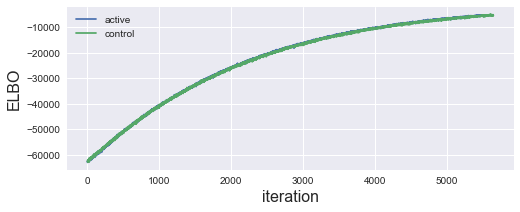

In [213]:
elbo_1 = -advi_active.hist
elbo_2 = -advi_control.hist

figsize = (8,3); fontsize = 16;
f, ax = plt.subplots(1,1,figsize=figsize);

ax.plot(elbo_1,label='active')
ax.plot(elbo_2,label='control')
ax.legend()
ax.set_ylabel('ELBO',fontsize=fontsize)
ax.set_xlabel('iteration',fontsize=fontsize);
sns.despine();

### Assess test performance

In [214]:
# Draw samples from variational posterior (the weights in the network)
n_draws = 200 # > 2k hangs for almost all network sizes on my 2018 MBP -SH
trace_control = approx_control.sample(draws=n_draws)
trace_active = approx_active.sample(draws=n_draws)

(n_test,n_input) = X_test.shape
test_x = theano.shared(X_test)
test_y = theano.shared(y_test)

# test active learning 
NN_model_test = construct_nn(test_x, test_y, n_input, n_output, n_test, n_hidden_1=128)
n_samples = 100
with NN_model_test:
    ppc_test_active = pm.sample_ppc(trace_active, samples=n_samples)

# test control
NN_model_test = construct_nn(test_x, test_y, n_input, n_output, n_test, n_hidden_1=128)
n_samples = 100
with NN_model_test:
    ppc_test_control = pm.sample_ppc(trace_control, samples=n_samples)

100%|██████████| 100/100 [00:50<00:00,  2.04it/s]


In [215]:
# Prediction is mode of each
test_y_pred_active = mode(ppc_test_active['out'], axis=0).mode[0,:]
test_y_pred_control = mode(ppc_test_control['out'], axis=0).mode[0,:]

mean_test_perf = np.mean(test_y_pred_active==y_test)
print("Network Test Set Performance Active Learning: {:f}".format(mean_test_perf))
mean_test_perf = np.mean(test_y_pred_control==y_test)
print("Network Test Set Performance Control: {:f}".format(mean_test_perf))

Network Test Set Performance Active Learning: 0.554500
Network Test Set Performance Control: 0.545600


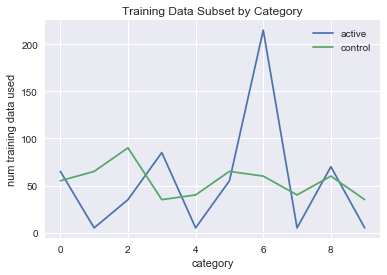

In [220]:
len_ind_used_active = [len(x) for x in ind_used_active]
len_ind_used_control = [len(x) for x in ind_used_control]

plt.plot(len_ind_used_active, label='active')
plt.plot(len_ind_used_control, label='control')
plt.title('Training Data Subset by Category')
plt.xlabel('category')
plt.ylabel('num training data used')
plt.legend()
plt.show()

error =  0.062037775028


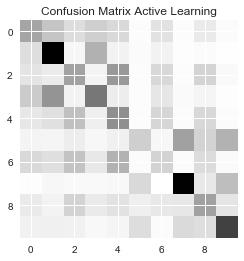

error =  0.065643954874


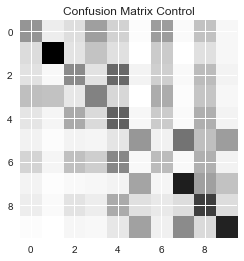

In [218]:
one_hot, cat_hist, cat_entropy, cat_KL = get_cat_entropy(X_test, y_test, ppc_test_active)
diff_identity = np.sum((cat_hist/np.sum(cat_hist) - np.eye(10)/10)**2)
print('error = ', diff_identity)
plt.figure(figsize=(4,4))
plt.imshow(cat_hist)
plt.title('Confusion Matrix Active Learning')
plt.show()

one_hot, cat_hist, cat_entropy, cat_KL = get_cat_entropy(X_test, y_test, ppc_test_control)
diff_identity = np.sum((cat_hist/np.sum(cat_hist) - np.eye(10)/10)**2)
print('error = ', diff_identity)
plt.figure(figsize=(4,4))
plt.imshow(cat_hist)
plt.title('Confusion Matrix Control')
plt.show()


This is a relatively contrived example of using active learning, but it is a very useful concept. It is particularly useful when computation time is a limited resource, and consequently it is very important to choose training data that will be most useful for improving performance. For example, in reinforcement learning uncertainty can be used to drive exploration. 

Notes: 
- amount of data replayed from each category
- Need to deal with getting enough replay point at beginning, or at least making sure the control is the same